<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/DL/UNET_FINAL_TEST_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


# DATASET PREPARATION 

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_ELA')
!unzip upd-tamp-ela1.zip -d /content/tamp-ela/

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_MASK')
!unzip upd-tamp-mask.zip -d /content/tamp-mask/

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_ORIG/data/CASIA2')
!unzip upd-tamp-orig.zip -d /content/tamp-orig/

In [5]:
list1 = os.listdir('/content/tamp-ela/tamp')
list2 = os.listdir('/content/tamp-mask/tamp')
list3 = os.listdir('/content/tamp-orig/upd-tamp')
print(len(list1), " tamp-ela")
print(len(list2), " tamp-mask")
print(len(list3), " tamp-orig")

3813  tamp-ela
3813  tamp-mask
3384  tamp-orig


In [6]:
list1[0:10]

['Tp_D_NRN_M_N_nat00091_nat00097_11099.jpg',
 'Tp_D_NNN_M_N_nat00026_nat00028_11036.jpg',
 'Tp_S_CRN_M_N_art00008_art00008_10743.jpg',
 'Tp_D_NNN_M_B_arc00040_nat00070_00260.jpg',
 'Tp_S_NND_S_N_sec00068_sec00068_00089.jpg',
 'Tp_S_NNN_S_N_arc20093_arc20093_01733.jpg',
 'Tp_D_NNN_M_O_art00052_nat10122_11849.jpg',
 'Tp_S_CNN_S_N_pla00067_pla00067_11217.jpg',
 'Tp_D_NRN_S_N_pla00091_ani00031_00935.jpg',
 'Tp_D_NRN_S_N_nat10115_cha00052_11477.jpg']

In [7]:
import os 
os.chdir('/content')
!mkdir train 

#### RENAMING THE UNZIPPED FOLDER #####
os.chdir('/content/tamp-mask')
os.rename('tamp','mask_images')
os.chdir('/content/tamp-ela')
os.rename('tamp','ela_images')
os.chdir('/content/tamp-orig')
os.rename('upd-tamp','orig_images')

### MOVE ALL THE FOLDERS IN A SINGLE DIRECTORIES UNDER THE NAME TRAIN WHICH IS CREATED JUST ABOVE ###

In [9]:
img_height = 128
img_width = 128
nb_epochs = 200
batch_size = 25
train_path = '/content/train'

In [ ]:
##### 4 DIMENSIONS #####

'''
def get_data(path,train = True):
  ids = os.listdir(path + "/orig_images")
  X = np.zeros((len(ids), img_height, img_width, 4), dtype=np.float32)
  if train:
    y = np.zeros((len(ids),img_height, img_width, 1), dtype=np.float32)
  print('Getting and resizing images ... ')
  for n, id_ in tqdm_notebook(enumerate(ids),total = len(ids)):
    # Load Images
    orig_img = load_img(path+'/orig_images/'+id_, grayscale=False, color_mode='rgb')
    ela_img = load_img(path + '/ela_images/' + id_, grayscale=True)

    x_orig_img = img_to_array(orig_img)
    x_ela_img = img_to_array(ela_img)

    x_orig_img = resize(x_orig_img, (img_height,img_width,3), mode = 'constant', preserve_range = True)
    x_ela_img = resize(x_ela_img, (img_height, img_width, 1), mode='constant', preserve_range=True)
    
    #print(x_orig_img.shape, " Shape of ELA Images")

    b,g,r = cv2.split(x_orig_img)
    #print(b.shape," Shape of b")
    x_ela_img = x_ela_img.squeeze()
    #print(x_ela_img.shape, " Shape of ELA Images")
    x_img = cv2.merge((r,g,b,x_ela_img))
    #print(x_img.shape, " Shape of final used images")
        # Load masks
    if train:
      mask = img_to_array(load_img(path + '/mask_images/' + id_, grayscale=True))
      mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)    

    # Save Images 
    X[n,...] = x_img/255 
    if train:
      y[n] = mask/255
  print("Done!")
  if train:
    return X, y 
  else :
    return X         


X, y = get_data(train_path, train = True)    
'''

'\ndef get_data(path,train = True):\n  ids = os.listdir(path + "/orig_images")\n  X = np.zeros((len(ids), img_height, img_width, 4), dtype=np.float32)\n  if train:\n    y = np.zeros((len(ids),img_height, img_width, 1), dtype=np.float32)\n  print(\'Getting and resizing images ... \')\n  for n, id_ in tqdm_notebook(enumerate(ids),total = len(ids)):\n    # Load Images\n    orig_img = load_img(path+\'/orig_images/\'+id_, grayscale=False, color_mode=\'rgb\')\n    ela_img = load_img(path + \'/ela_images/\' + id_, grayscale=True)\n\n    x_orig_img = img_to_array(orig_img)\n    x_ela_img = img_to_array(ela_img)\n\n    x_orig_img = resize(x_orig_img, (img_height,img_width,3), mode = \'constant\', preserve_range = True)\n    x_ela_img = resize(x_ela_img, (img_height, img_width, 1), mode=\'constant\', preserve_range=True)\n    \n    #print(x_orig_img.shape, " Shape of ELA Images")\n\n    b,g,r = cv2.split(x_orig_img)\n    #print(b.shape," Shape of b")\n    x_ela_img = x_ela_img.squeeze()\n    #pr

In [10]:
#### 2 DIMENSIONS ####

def get_data(path,train = True):
  ids = os.listdir(path + "/orig_images")
  X = np.zeros((len(ids), img_height, img_width, 2), dtype=np.float32)
  if train:
    y = np.zeros((len(ids),img_height, img_width, 1), dtype=np.float32)
  print('Getting and resizing images ... ')
  for n, id_ in tqdm_notebook(enumerate(ids),total = len(ids)):
    # Load Images
    orig_img = load_img(path+'/orig_images/'+id_, grayscale=True)
    ela_img = load_img(path + '/ela_images/' + id_, grayscale=True)

    x_orig_img = img_to_array(orig_img)
    x_ela_img = img_to_array(ela_img)

    x_orig_img = resize(x_orig_img, (img_height,img_width,1), mode = 'constant', preserve_range = True)
    x_ela_img = resize(x_ela_img, (img_height, img_width, 1), mode='constant', preserve_range=True)
    

    x_orig_img = x_orig_img.squeeze()
    x_ela_img = x_ela_img.squeeze()
    #print(x_ela_img.shape, " Shape of ELA Images")
    x_img = cv2.merge((x_orig_img,x_ela_img))
    #print(x_img.shape, " Shape of final used images")
        # Load masks
    if train:
      mask = img_to_array(load_img(path + '/mask_images/' + id_, grayscale=True))
      mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)    

    # Save Images 
    X[n,...] = x_img/255 
    if train:
      y[n] = mask/255
  print("Done!")
  if train:
    return X, y 
  else :
    return X         

train_path = '/content/train'
X, y = get_data(train_path, train = True)    


Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [11]:
print(X.shape)

(3384, 128, 128, 2)


In [ ]:
#### 1 Dimension ####

'''
#### Get and resize train images and masks ######
def get_data(path, train=True):
    ids = os.listdir(path + "/ela_images")
    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/ela_images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (img_height, img_width, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/mask_images/' + id_, grayscale=True))
            mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)

        # Save images
        X[n,...,0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

train_path = '/content/train'    
X, y = get_data(train_path, train=True)

print(X.shape)

'''

'\n#### Get and resize train images and masks ######\ndef get_data(path, train=True):\n    ids = os.listdir(path + "/ela_images")\n    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)\n    if train:\n        y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)\n    print(\'Getting and resizing images ... \')\n    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):\n        # Load images\n        img = load_img(path + \'/ela_images/\' + id_, grayscale=True)\n        x_img = img_to_array(img)\n        x_img = resize(x_img, (img_height, img_width, 1), mode=\'constant\', preserve_range=True)\n\n        # Load masks\n        if train:\n            mask = img_to_array(load_img(path + \'/mask_images/\' + id_, grayscale=True))\n            mask = resize(mask, (img_height, img_width, 1), mode=\'constant\', preserve_range=True)\n\n        # Save images\n        X[n,...,0] = x_img.squeeze() / 255\n        if train:\n            y[n] = mask / 255\n    p

In [12]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

# Custom Layer

In [16]:
class Customconstraint1():
  
  def __call__(self,filter):
    print(filter.shape , " Shape of filter")
    conditions = np.ones((3,3,2,64))
    print(conditions.shape)

    for i in range(64):
      for j in range(2):
        conditions[1,1,j,i] = 0

    conditions = ((conditions > 0).tolist())
    update1 = tf.zeros(shape = [3,3,2,64], dtype = tf.float32)

    temp1 = tf.where(conditions,filter,update1)
    sum = tf.math.reduce_sum(temp1, axis = [0,1])    

    temp2 = tf.divide(temp1,sum)

    update2 = tf.ones(shape = [3,3,2,64], dtype = tf.float32)
    update2 = tf.math.negative(update2)

    temp3 = tf.where(conditions,temp2,update2)

    return temp3

In [17]:
class Customconstraint2():
  
  def __call__(self,filter):
    print(filter.shape , " Shape of filter")
    conditions = np.ones((3,3,64,64))
    print(conditions.shape)

    for i in range(64):
      for j in range(2):
        conditions[1,1,j,i] = 0

    conditions = ((conditions > 0).tolist())
    update1 = tf.zeros(shape = [3,3,64,64], dtype = tf.float32)

    temp1 = tf.where(conditions,filter,update1)
    sum = tf.math.reduce_sum(temp1, axis = [0,1])    

    temp2 = tf.divide(temp1,sum)

    update2 = tf.ones(shape = [3,3,64,64], dtype = tf.float32)
    update2 = tf.math.negative(update2)

    temp3 = tf.where(conditions,temp2,update2)

    return temp3

# CALLBACKS 

In [18]:
#### CALLBACKS ####

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint('/content/drive/My Drive/weights/unet_aug200-test3-batchnorm-cust-2d.h5', verbose=1, save_best_only=True, save_weights_only=True)

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, min_lr=0.00001, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):

  if epoch < 10:
     return 0.001
  else:
     return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))
lr_schedule = LearningRateScheduler(scheduler) 

### EARLY STOPPING
early_stopping = EarlyStopping(patience=10, verbose=1)


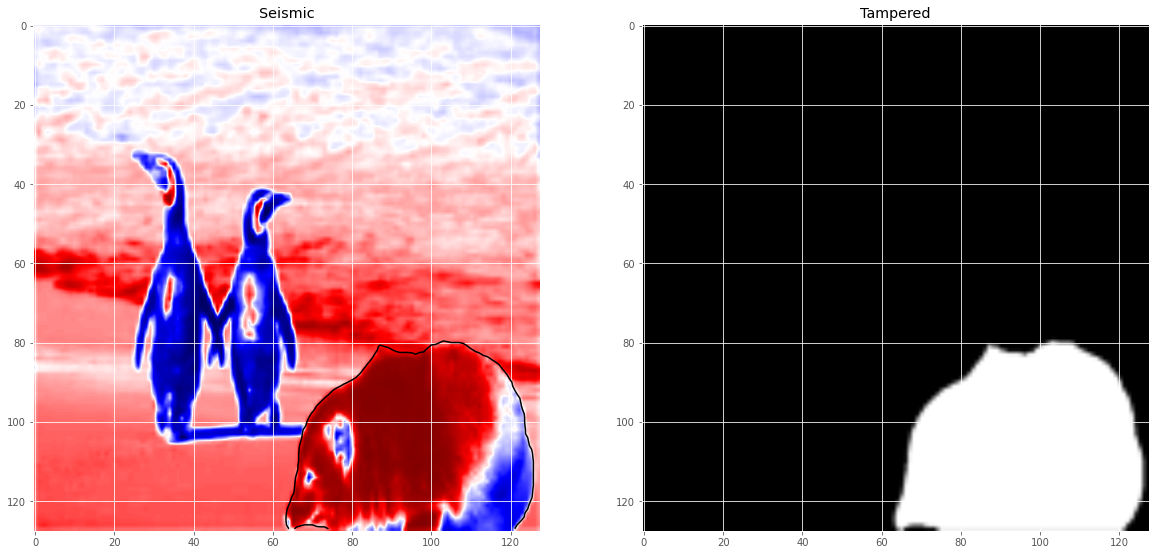

In [19]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Tampered');

# MODEL AND COMPILATION


In [20]:
def unet(input_size = (256,256,2)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_constraint = Customconstraint1())(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_constraint = Customconstraint2())(conv1)
    batch =  BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    batch1 =  BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch1)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    batch2 =  BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    batch3 =  BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(batch3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    batch4 =  BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(batch4)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    batch5 =  BatchNormalization()(up6)
    merge6 = concatenate([drop4,batch5], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    batch6 =  BatchNormalization()(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(batch6))
    batch7 =  BatchNormalization()(up7)
    merge7 = concatenate([conv3,batch7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    batch8 =  BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(batch8))
    batch9 =  BatchNormalization()(up8)
    merge8 = concatenate([conv2,batch9], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    batch10 =  BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(batch10))
    batch11 =  BatchNormalization()(up9)
    merge9 = concatenate([conv1,batch11], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    batch12 =  BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch12)
    batch13 =  BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch13)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    
    return model

In [21]:
model = unet(input_size = (img_height, img_width, 2))
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [22]:
model.load_weights('/content/drive/My Drive/weights/unet_aug200-test3-batchnorm-cust-2d.h5')

In [23]:
### AUGMENTATION ###

data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2020
bs = 25

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2876, 128, 128, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
### With Flips Augmentation ###
results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=nb_epochs, callbacks=[save,lr_schedule,reduce_lr],
                              validation_data=(X_valid, y_valid))

### Without Augmentations ###
#results = model.fit(X_train, y_train, batch_size=batch_size, epochs= nb_epochs, callbacks=[early_stopping,save,lr_schedule, reduce_lr ],
#                    validation_data=(X_valid, y_valid))

(3, 3, 2, 64)  Shape of filter
(3, 3, 2, 64)
(3, 3, 64, 64)  Shape of filter
(3, 3, 64, 64)
Epoch 1/200
115/115 [==============================] - 89s 778ms/step - loss: 0.4394 - accuracy: 0.8524 - val_loss: 0.3758 - val_accuracy: 0.8719

Epoch 00001: val_loss improved from inf to 0.37578, saving model to /content/drive/My Drive/weights/unet_aug200-test3-batchnorm-cust-2d.h5
Epoch 2/200
115/115 [==============================] - 77s 666ms/step - loss: 0.3553 - accuracy: 0.8691 - val_loss: 0.3391 - val_accuracy: 0.8815

Epoch 00002: val_loss improved from 0.37578 to 0.33905, saving model to /content/drive/My Drive/weights/unet_aug200-test3-batchnorm-cust-2d.h5
Epoch 3/200
115/115 [==============================] - 74s 646ms/step - loss: 0.3429 - accuracy: 0.8695 - val_loss: 0.4248 - val_accuracy: 0.8748

Epoch 00003: val_loss did not improve from 0.33905
Epoch 4/200
115/115 [==============================] - 74s 646ms/step - loss: 0.3448 - accuracy: 0.8680 - val_loss: 0.3525 - val_accur

# VISUALIZATION

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [24]:
model.evaluate(X_valid, y_valid, verbose=1)
print("validation-loss, validation-acc")

508/508 [==============================] - 20s 40ms/step
validation-loss, validation-acc


# PREDICTION ON THE DATASET 

In [25]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

508/508 [==============================] - 7s 14ms/step


In [26]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original-image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('tampering-actual')
 
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('tampering Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('tampering Predicted binary');

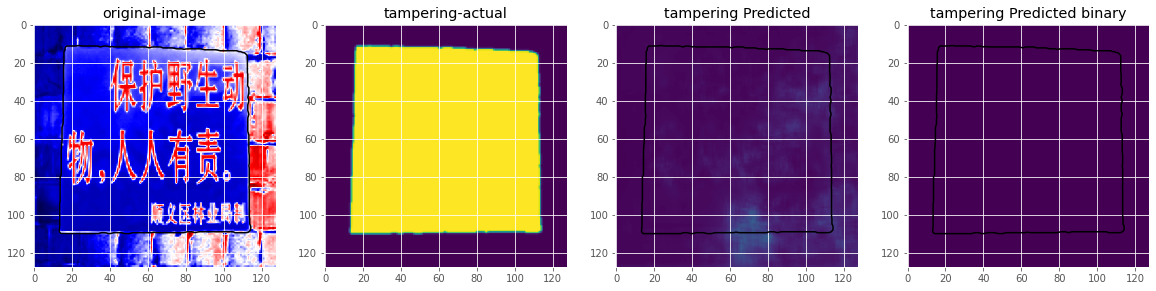

In [27]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=8)

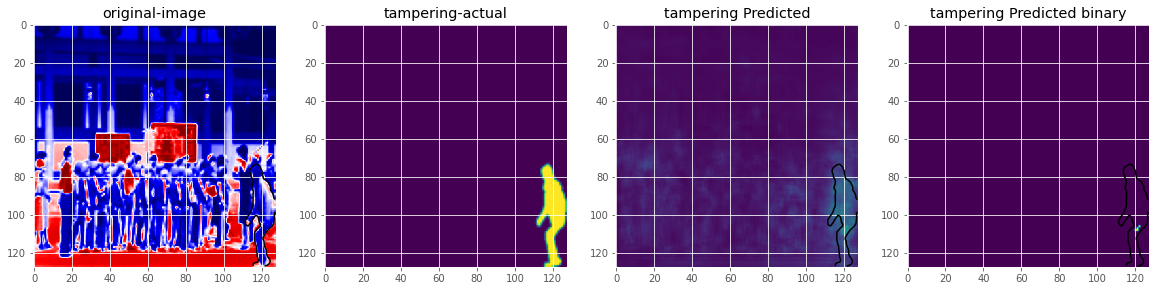

In [32]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=17)

# PREDICTION ON A CUSTOM IMAGE

In [ ]:
 import cv2
image_path = 'ela_spliced_image.png'
img = cv2.imread(image_path,0)
print(img.shape)
img = cv2.resize(img,(128,128))
print(img.shape)
img = np.expand_dims(img,axis = 0)
img = np.expand_dims(img,axis = -1)
print(img.shape)


os.chdir('/content')
preds_val = model.predict(img, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)

(548, 796)
(128, 128)
(1, 128, 128, 1)
